# Intro

**PyTorch Geometric (PyG)** is a principal tool for building graph neural network models and experimenting with various graph convolutions. Concurrently, **PyTorch Lightning (PL)** is a prevalent library for automating the learning process of Torch models, monitoring it, and tuning parameters.  
   
While both tools are well-known and frequently utilized, there is a dearth of tutorials demonstrating how to seamlessly integrate them. Although the process is not particularly complicated or different from the separate use of these two libraries, there are minor tweaks and details that users need to be mindful of.  
   
In this tutorial, I will provide an example of how to:  
   
1. Load graph data that will be used in our operations. Our task is link prediction, which answers two questions: which two nodes should be linked with each other?  
2. Prepare the data for modelling by performing a transductive split.  
3. Prepare dedicated graph data loaders for batching.  
4. Build a model and a PyTorch Lightning wrapper around it.  
5. Train the model using the PL Trainer class.  
6. Check the model's performance.

The code for this tutorial is also available as a [Kaggle notebook](https://www.kaggle.com/code/draken/graph-nn-pytorch-geometric-lightning-perfect-match). If you like it - please leave an upvote there :) 

# Lib install

We will commence with the installation of the necessary libraries. This step is mandatory if you are executing the notebook in a Kaggle or Google Colab environment. Otherwise, you might already have these libraries installed on your system.  

In [1]:
%pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=a1342185b2ea7ddbc3797f630804c891999aec5e80caed58df2a1a4b69c226f0
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Note: you may need to restart the kernel to use updated packages.


<div class="alert alert-warning">
For an unknown reason, currently in Kaggle.com notebooks building wheels for torch_scatter and torch sparse takes very long time. This is expected (for now), so be patient.
</div>

In [2]:
%pip install torch_scatter torch_sparse torch_cluster torch_spline_conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=493893 sha256=6285a1eaf21dfbb10534bab72b03b245011e53f0791f8ae342a780d8a5d32327
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch_sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1087508 sha256=1608ff9314b911e20a85102c9d1f1322d06ed92a58f290bcb9f7b19273e4fb9a
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created wheel for torch_

# Lib imports

Let's import the libraries that we need for this exercise:  
   
1. **Torch** - This general library will assist us in building subclasses and using various utilities.  
2. **Torch Geometric** - This is the primary library for graph neural networks.  
3. **PyTorch Lightning** - This library is used for training, tuning, and validating models.  
4. **Sklearn Metrics and Torchmetrics** - These will be used to check the performance of the model.  
   

In [3]:
import torch_geometric as tg
import torch_geometric.nn as tgnn
import torch as th
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics as tm
import networkx as nx

from sklearn.metrics import classification_report
from typing import Tuple

# Load data

We will be working with the Cora ML Citation dataset in the Machine Learning area. 
The dataset can be accessed via the Torch Geometric Datasets module. You can find out more about it [here](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.CitationFull.html#torch_geometric.datasets.CitationFull).  

In [4]:
data = tg.datasets.CitationFull(root="data", name="Cora_ML")

Processing...
Done!


By default, Torch Geometric datasets can return multiple graphs. However, in our case, we only have one graph to work with.  

In [5]:
data[0]

Data(x=[2995, 2879], edge_index=[2, 16316], y=[2995])

## Links splitting

We will begin by splitting links in our dataset. We will use 20% of graph connections as a validation set and 10% as a test set. We will not add negative samples to the training dataset, as such negative links will be created on-the-fly by the data loader.  
   
The concept of negative sampling is well-known and widely used, especially in natural language processing. To learn more about it, you can read [this excellent post by Chris McCormick](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/).  
   
In general, negative sampling creates "fake" samples (in our case, connections between nodes), so the model learns how to distinguish real connections. Negative sampling has some nice statistical properties, grounded in the theory and mathematics of sampling.  

In [6]:
tg.seed_everything(123)

In [7]:
link_splitter = tg.transforms.RandomLinkSplit(
    num_val=0.2, 
    num_test=0.1, 
    add_negative_train_samples=False,
    disjoint_train_ratio=0.8)

Now let's split our data

In [8]:
train_g, val_g, test_g = link_splitter(data[0])

In [9]:
train_g

Data(x=[2995, 2879], edge_index=[2, 2285], y=[2995], edge_label=[9137], edge_label_index=[2, 9137])

We have some new attributes:  
   
1. Edge label - that describes if the edge is true/fake. **This is what we want to predict**.  
2. Edge label index - 2 x NUM EDGES matrix, that stores node connections.  
   
Let's investigate the distribution of positive and negative samples.  We have some new attributes:
1. Edge label - that describes if the edge is true/fake. **This is what we want to predict**.
2. Edge label index - 2 x NUM EDGES matrix, that stores node connections.

Let's investigate the distribution of positive and negative samples

In [10]:
th.unique(train_g.edge_label, return_counts=True)

(tensor([1.]), tensor([9137]))

In [11]:
th.unique(val_g.edge_label, return_counts=True)

(tensor([0., 1.]), tensor([3263, 3263]))

In [12]:
th.unique(val_g.edge_label, return_counts=True)

(tensor([0., 1.]), tensor([3263, 3263]))

# Model

## GNN module

Let's build a GNN part of our model - the one that will be responsible for generating graph embeddings.  
   
This is a typical `torch.nn.Module` with graph convolutions from PyG.  

In [13]:
class GNN(nn.Module):
    
    def __init__(
        self, 
        dim_in: int, 
        conv_sizes: Tuple[int, ...], 
        act_f: nn.Module = th.relu, 
        dropout: float = 0.1,
        *args, 
        **kwargs):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = conv_sizes[-1]
        self.dropout = dropout
        self.act_f = act_f
        last_in = dim_in
        layers = []
        
        # Here we build subsequent graph convolutions.
        for conv_sz in conv_sizes:
            conv = tgnn.SAGEConv(in_channels=last_in, out_channels=conv_sz, *args, **kwargs)
            last_in = conv_sz
            layers.append(conv)
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x: th.Tensor, edge_index: th.Tensor) -> th.Tensor:
        h = x
        for conv in self.layers:
            h = conv(h, edge_index)
            h = self.act_f(h)
            if self.dropout:
                h = nn.functional.dropout(h, p=self.dropout, training=self.training)
        return h

Notable part of this model is set of graph convolutions - in our case `SAGEConv`. Formally SAGE convolution is defined as:  
   
$$  
\begin{align*}  
h_{\mathcal{N}(v)}^k &\leftarrow AGG\big(\{ h_u^{l-1}, \forall u \in N(v)\}\big) \\[1em]  
h_v^l &\leftarrow \sigma\bigg(W^l \cdot CONCAT\big(h_v^{l-1}, AGG\big(\{ h_u^{l-1}, \forall u \in N(v)\}\big) \big)\bigg)  
\end{align*}  
$$  
   
With $v$ being a current node, and $\mathcal{N}(v)$ - neighbors of node v.  
   
To know more about this convolution type, check the original paper of GraphSAGE:  
   
> Hamilton, W., Ying, Z., & Leskovec, J. (2017). Inductive representation learning on large graphs. Advances in neural information processing systems, 30.  
   
Available through Arxiv: https://arxiv.org/abs/1706.02216  
   
Let's check if our model can make predictions using the data, that we have prepared. Notice, one fact: **PyG models accept matrix of node features X and edge_index - defining connections**.  
   

In [14]:
gnn = GNN(train_g.x.size()[1], conv_sizes=[512, 256, 128])
with th.no_grad():
    out = gnn(train_g.x, train_g.edge_index)
    
out

tensor([[0.0000, 0.0000, 0.0051,  ..., 0.0997, 0.0000, 0.0000],
        [0.0107, 0.0000, 0.0576,  ..., 0.0651, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0102,  ..., 0.0973, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0549,  ..., 0.0671, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0166,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0034,  ..., 0.1111, 0.0000, 0.0000]])

The output from our model is a **matrix of node embeddings** of dimension: `N nodes x Embed size`.  

## PyTorch Lightning Wrapper  
   
Now it is time to define our PL wrapper around the graph convolution. This model will contain the following elements:  
   
1. **"Inner graph convolution"** - the part that we have defined so far. The Graph convolution part returns node embeddings.  
2. **Link prediction layer** - this layer will take the source node embeddings (message senders) and target node embeddings (message receivers) and compute a product between them and then add some non-linearity. This will assist the model in deciding whether there should be a link or not.  

In [15]:
class LinkPredModel(pl.LightningModule):
    
    def __init__(
        self,
        dim_in: int,
        conv_sizes: Tuple[int, ...], 
        act_f: nn.Module = th.relu, 
        dropout: float = 0.1,
        lr: float = 0.01,
        *args, **kwargs):
        super().__init__()
        
        # Our inner GNN model
        self.gnn = GNN(dim_in, conv_sizes=conv_sizes, act_f=act_f, dropout=dropout)
        
        # Final prediction model on links.
        self.lin_pred = nn.Linear(self.gnn.dim_out, 1)
        self.lr = lr
    
    def forward(self, x: th.Tensor, edge_index: th.Tensor) -> th.Tensor:
        # Step 1: make node embeddings using GNN.
        h = self.gnn(x, edge_index)
        
        # Take source nodes embeddings- senders
        h_src = h[edge_index[0, :]]
        # Take target node embeddings - receivers
        h_dst = h[edge_index[1, :]]
        
        # Calculate the product between them
        src_dst_mult = h_src * h_dst
        # Apply non-linearity
        out = self.lin_pred(src_dst_mult)
        return out
    
    def _step(self, batch: th.Tensor, phase: str='train') -> th.Tensor:
        yhat_edge = self(batch.x, batch.edge_label_index).squeeze()
        y = batch.edge_label
        loss = nn.functional.binary_cross_entropy_with_logits(input=yhat_edge, target=y)
        f1 = tm.functional.f1_score(preds=yhat_edge, target=y, task='binary')
        prec = tm.functional.precision(preds=yhat_edge, target=y, task='binary')
        recall = tm.functional.recall(preds=yhat_edge, target=y, task='binary')
        
        # Watch for logging here - we need to provide batch_size, as (at the time of this implementation)
        # PL cannot understand the batch size.
        self.log(f"{phase}_f1", f1, batch_size=batch.edge_label_index.shape[1])
        self.log(f"{phase}_loss", loss, batch_size=batch.edge_label_index.shape[1])
        self.log(f"{phase}_precision", prec, batch_size=batch.edge_label_index.shape[1])
        self.log(f"{phase}_recall", recall, batch_size=batch.edge_label_index.shape[1])

        return loss
    
    def training_step(self, batch, batch_idx):
        return self._step(batch)
    
    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")
    
    def predict_step(self, batch):
        x, edge_index = batch
        return self(x, edge_index)
    
    def configure_optimizers(self):
        return th.optim.Adam(self.parameters(), lr=self.lr)

The code above is a typical "boilerplate" from Pytorch Lightning with two exceptions:  
1. **Forward loop** - contains two steps: node embeddings using GNN and link prediction.  
2. **Logging with batch size** - currently PL cannot understand the batch size from graph data, so we need to instruct it, providing the dimensionality of **edge_label_index** - the number of labeled connections in our batch.  
   
Again, we can check if the model works at all.  

In [16]:
model = LinkPredModel(val_g.x.size()[1], conv_sizes=[512, 256, 128])
with th.no_grad():
    out = model.predict_step((val_g.x, val_g.edge_label_index))

# Training the Model  
   
Now it is time for a training loop. Again, no surprises here, with one exception: **special data loaders**.  
   
Graph data requires special treatment - especially for link prediction. PyG has some specialized data loader classes, that are responsible for properly generating batches.  
In our case, we will use: `tg.loader.LinkNeighborLoader` that takes the following inputs:  
   
1. The data (graph) to be loaded in batches.  
2. `num_neighbors` - maximum number of neighbors of each node to be loaded during one "hop". A list specifying the number of neighbors one-two-three-...-K hops away. Especially useful for very large graphs.  
3. `edge_label_index` - which attribute (is any) already indicates true/fake connections.  
4. `neg_sampling_ratio` - proportion of negative samples to real ones.  
   

In [17]:
train_loader = tg.loader.LinkNeighborLoader(
    train_g,
    num_neighbors=[-1, 10, 5],
    batch_size=128,
    edge_label_index=train_g.edge_label_index,
    neg_sampling_ratio=0.5
)

val_loader = tg.loader.LinkNeighborLoader(
    val_g,
    num_neighbors=[-1, 10, 5],
    batch_size=128,
    edge_label_index=val_g.edge_label_index,
    edge_label=val_g.edge_label,
    neg_sampling_ratio=0.0
)

test_loader = tg.loader.LinkNeighborLoader(
    test_g,
    num_neighbors=[-1, 10, 5],
    batch_size=128,
    edge_label_index=test_g.edge_label_index,
    edge_label=test_g.edge_label,
    neg_sampling_ratio=0.0
)

/opt/conda/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


Now it is time for a typical, boilerplate trianing loops with PL.

In [18]:
model = LinkPredModel(val_g.x.size()[1], conv_sizes=[512, 256, 128])
trainer = pl.Trainer(max_epochs=20, log_every_n_steps=5)

# Validate before training - we will see results of untrained model.
trainer.validate(model, val_loader)

# Train the model
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │            0.0            │
│         val_loss          │    0.6932837963104248     │
│       val_precision       │            0.0            │
│        val_recall         │            0.0            │
└───────────────────────────┴───────────────────────────┘

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
# Check the model after training
trainer.validate(model, val_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.4285476803779602     │
│         val_loss          │    0.4845980405807495     │
│       val_precision       │    0.5069091320037842     │
│        val_recall         │    0.3716221749782562     │
└───────────────────────────┴───────────────────────────┘

[{'val_f1': 0.4285476803779602,
  'val_loss': 0.4845980405807495,
  'val_precision': 0.5069091320037842,
  'val_recall': 0.3716221749782562}]

Check the model performance on test set.

In [20]:
trainer.test(model, test_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.4290732443332672     │
│         test_loss         │    0.4576335847377777     │
│      test_precision       │     0.508023738861084     │
│        test_recall        │    0.3720610737800598     │
└───────────────────────────┴───────────────────────────┘

[{'test_f1': 0.4290732443332672,
  'test_loss': 0.4576335847377777,
  'test_precision': 0.508023738861084,
  'test_recall': 0.3720610737800598}]

# Test data check

We can now run a final check on the test data - to see the classification report and ROC AUC curve.  


In [21]:
with th.no_grad():
    yhat_test_proba = th.sigmoid(model(test_g.x, test_g.edge_label_index)).squeeze()
    yhat_test_cls = yhat_test_proba >= 0.5
    
print(classification_report(y_true=test_g.edge_label, y_pred=yhat_test_cls))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69      1631
         1.0       0.69      0.66      0.68      1631

    accuracy                           0.68      3262
   macro avg       0.68      0.68      0.68      3262
weighted avg       0.68      0.68      0.68      3262



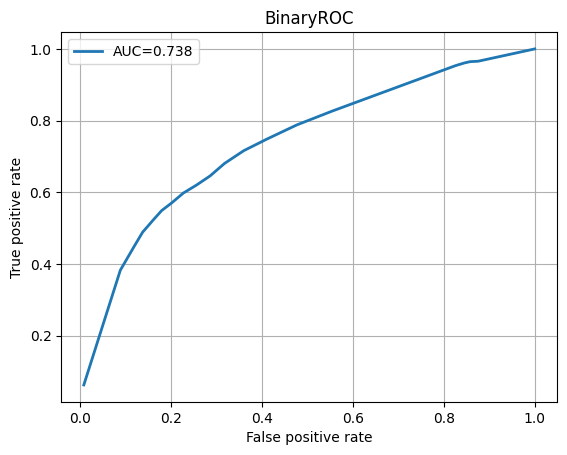

In [22]:
binary_roc = tm.classification.BinaryROC(thresholds=20)
binary_roc(yhat_test_proba, test_g.edge_label.to(th.long))
fig_, ax_ = binary_roc.plot(score=True)


The model we trained here was not particularly complex or carefully tuned, but it gets the job done. Now you can play with it if you want to improve its performance.

# Conclusion

 
In this tutorial, we have walked through the steps of integrating PyTorch Geometric and PyTorch Lightning to train a graph neural network. We have also delved into some of the nuances that come with using these two powerful libraries together.   
  
In summary, we covered:  
   
1. Loading and processing graph data.  
2. Building a GNN model and integrating it with PyTorch Lightning.  
3. Training the model using custom data loaders that are designed for graph data.  
4. Evaluating the model's performance on a test set.  
   
Despite its apparent complexity, the combination of PyTorch Geometric and PyTorch Lightning provides a good solution for quick prototyping and training graph neural networks. By following the steps laid out in this tutorial, you should be able to utilize these tools effectively in your own projects.